In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

/Users/admiraldoge/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
df = pd.read_csv('noticias.csv')
df.head(10)

,periodico,titulo,cuerpo,fecha,categoria
0,La Razon,El Gobierno refuerza plan para ‘insertar’ 11.0...,"De cara a la crisis, el Gobierno reforzó los p...",01-07-2020,economia
1,La Razon,Revilla descarta incremento de pasajes y Arias...,Varios sindicatos del transporte público se ha...,01-07-2020,sociedad
2,La Razon,Murillo ordena buscar a cabecillas del ‘grupo ...,"El ministro de Gobierno, Arturo Murillo, anunc...",01-07-2020,sociedad
3,La Razon,Más de 100 militares de Colombia implicados en...,El alto mando del ejército de Colombia reconoc...,01-07-2020,mundial
4,La Razon,Las fiestas julias serán con pocas personas y ...,Las fiestas julias de este año serán distintas...,01-07-2020,sociedad
5,La Razon,Arce denuncia que el Gobierno paró la compra d...,"En respuesta a una denuncia en su contra, el e...",01-07-2020,nacional
6,La Razon,Óscar Urenda continúa en una ‘situación muy de...,Ha transcurrido casi un mes y el secretario de...,01-07-2020,sociedad
7,La Razon,La Asamblea sanciona la ley que fija descuento...,La Asamblea Legislativa Plurinacional sancionó...,30-06-2020,sociedad
8,La Razon,Educación y futuro,Hace décadas que la educación en Bolivia no lo...,01-07-2020,opinion
9,La Razon,Teresa se llamaba dolor,Villa-Matas pega en el clavo: “no se escribe —...,01-07-2020,opinion


In [6]:
df.shape

(244, 5)

In [7]:
df.index = range(244)
df['titulo'].apply(lambda x: len(x.split(' '))).sum()

2822

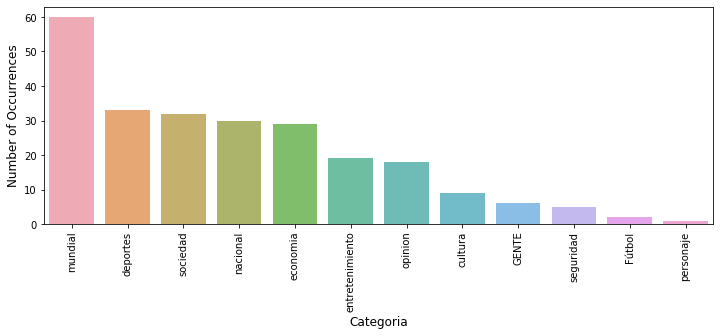

In [8]:
cnt_pro = df['categoria'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [9]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['cuerpo'] = df['cuerpo'].apply(cleanText)

In [29]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
tokenizer = nltk.data.load('tokenizers/punkt/spanish.pickle')
with open('spanish.txt') as f:
    lines = f.read().splitlines()
def tokenize_text(text):
    tokens = []
    for sent in tokenizer.tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            if word in lines:
                continue;
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['cuerpo']), tags=[r.categoria]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['cuerpo']), tags=[r.categoria]), axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/admiraldoge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
train_tagged.values[30]

TaggedDocument(words=['comunicado', 'dirigido', 'comunidad', 'internacional', 'cancillería', 'acusó', 'evo', 'morales', 'afines', 'sectores', 'afines', 'señor', 'morales', 'intentan', 'desestabilizar', 'país', 'causar', 'caos', 'profundizar', 'crisis', 'sanitaria', 'llegando', 'inclusive', 'negar', 'eistencia', 'misma', 'enfermedad', 'vez', 'dice', 'comunicado', 'agrega', 'mismo', 'tiempo', 'asamblea', 'legislativa', 'plurinacional', 'controlada', 'señor', 'morales', 'inescrupuloso', 'atentado', 'salud', 'vida', 'bolivianos', 'comunicado', 'señala', 'además', 'morales', 'aliados', 'convocado', 'etremistas', 'resguardados', 'mencionado', 'caso', 'tardanza', 'ratificar', 'ascensos', 'fuerzas', 'armadas', 'aprobación', 'ley', 'ecepción', 'cancillería', 'denunció', 'morales', 'complicidad', 'nicolás', 'maduro', 'hace', 'asilo', 'refugio', 'otorgado', 'gobierno', 'argentino', 'acota', 'teto', 'marco', 'gobierno', 'bolivia', 'riguroso', 'rechazo', 'condena', 'violentos', 'actores', 'narcoter

In [31]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [32]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 170/170 [00:00<00:00, 809343.56it/s]


In [33]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 170/170 [00:00<00:00, 987578.50it/s]


CPU times: user 2.4 s, sys: 144 ms, total: 2.54 s
Wall time: 955 ms


In [34]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [36]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter = 20000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.35135135135135137
Testing F1 score: 0.3412359728149202
